In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [2]:
data1 = pd.read_csv('data_01.csv')
data2 = pd.read_csv('data_02.csv')
data3 = pd.read_csv('data_03.csv')
data4 = pd.read_csv('data_04.csv')
data5 = pd.read_csv('data_05.csv')
data6 = pd.read_csv('data_06.csv')

In [3]:
data = [data1,data2,data3,data4,data5,data6]

In [4]:
df = pd.concat(data)

In [5]:
lens=[]
for df in data:
    lens.append(len(df))

In [6]:
lens

[55, 50, 55, 53, 47, 2]

In [7]:
indices = []
for i, count in enumerate(lens):
    for _ in range(count):
        indices.append(i)

In [8]:
dfs = [data1,data2,data3,data4,data5,data6]
lens = [data[i].shape[0] for i in range(len(data))]
indices = []
for i, count in enumerate(lens):
      for _ in range(count):
        indices.append(i)

df = pd.concat(dfs)
x = df['x']
y = df['y']

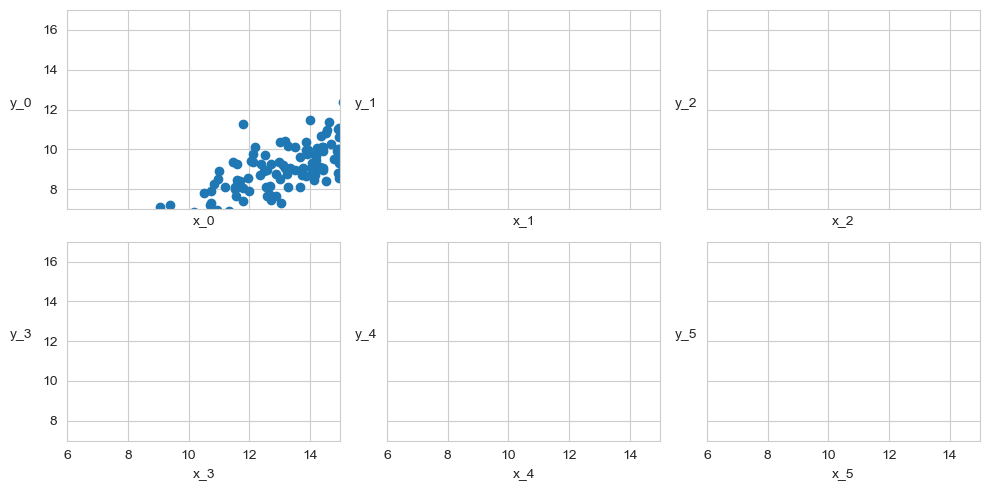

In [9]:
N = len(df)
M = 6
idx = np.repeat(range(M-1), N)
idx = np.append(idx,5)
idx = np.append(idx,5)
np.random.seed(42)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

x_m = df['x']
y_m = df['y']

_, ax = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


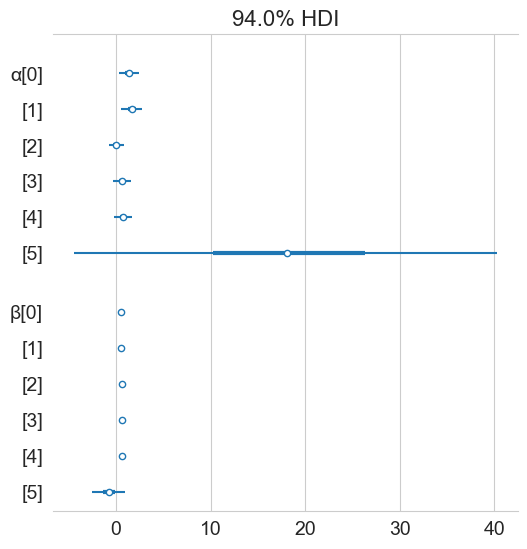

In [10]:
M = 6

x_centered = x - x.mean()

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[indices] + β[indices] * x_centered,
                         sigma=ε, nu=ν, observed=y)

    α = pm.Deterministic('α', α_tmp - β * x.mean())

    trace_up = pm.sample(2000, idata_kwargs={"log_likelihood": True})
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True);

In [11]:
len(indices)

262

In [12]:
len(idx)

1312

In [13]:
len(idx)

1312

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


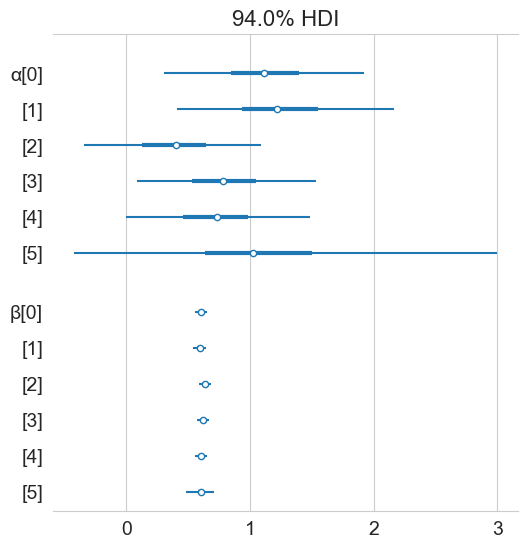

In [14]:
with pm.Model() as hierarchical_model:
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[indices] + β[indices] * x_centered,
                         sigma=ε, nu=ν, observed=y)

    α = pm.Deterministic('α', α_tmp - β * x.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x.mean())

    trace_hm = pm.sample(3000,tune = 1000, idata_kwargs={"log_likelihood": True})

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

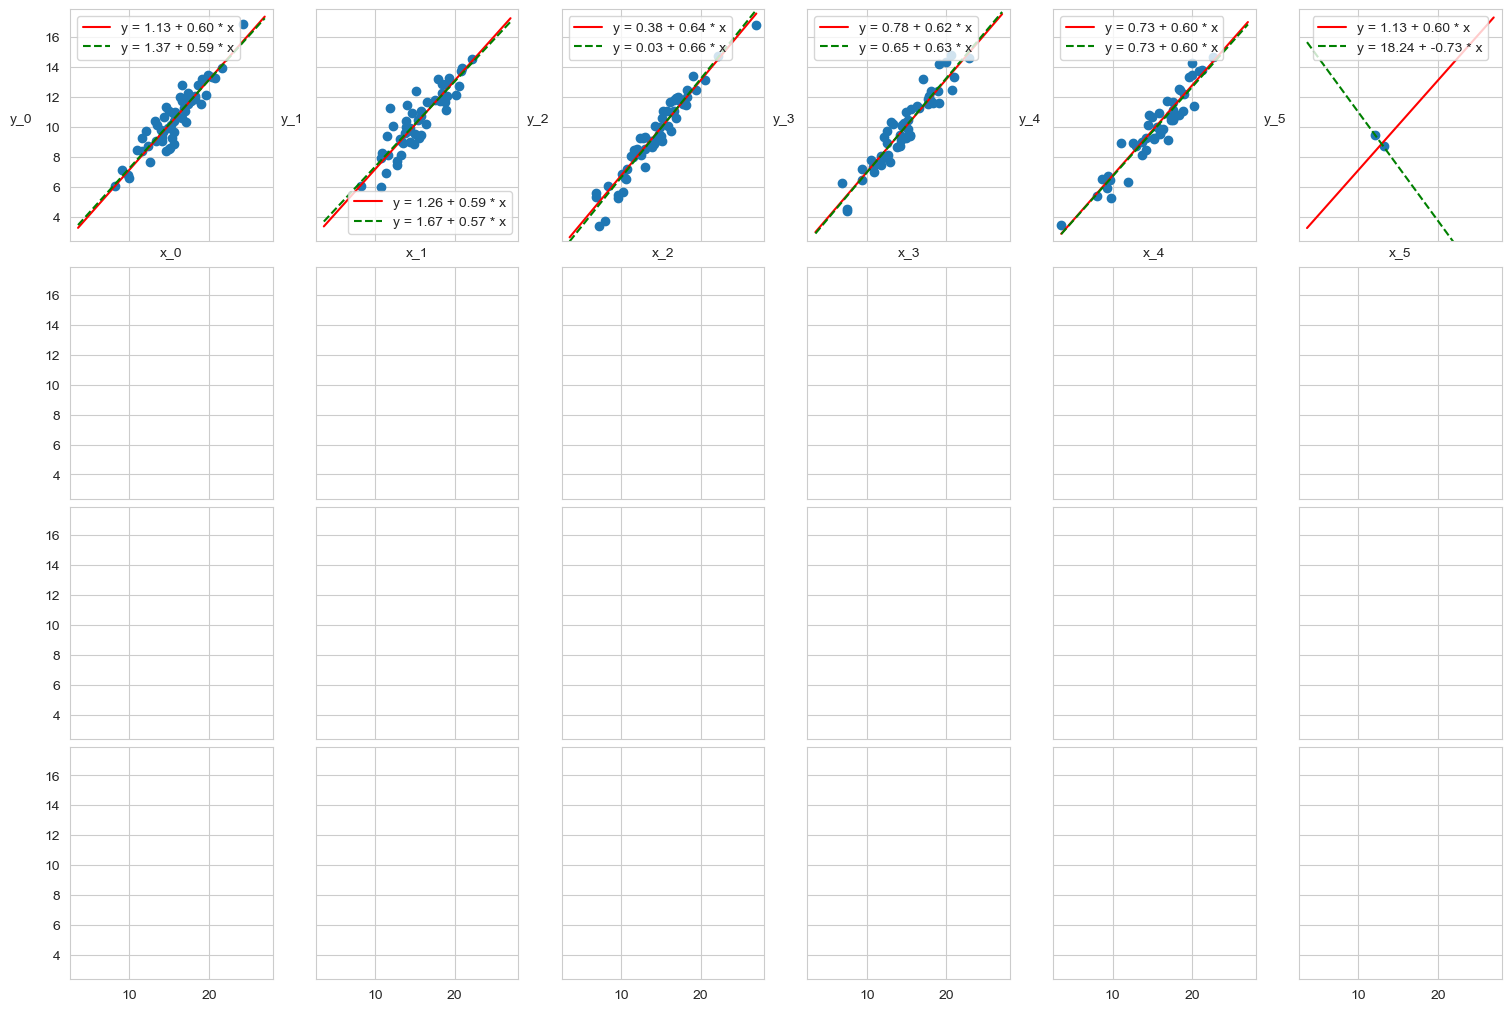

In [15]:
_, ax = plt.subplots(4, 6, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})
trace_upp = trace_up.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j, k = 0, indices.count(0)
x_range = np.linspace(x.min(), x.max(), 10)

for i in range(M):
    ax[i].scatter(x[j:k], y[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

    alpha_o = trace_upp['α'].sel({'α_dim_0':i}).mean().item()
    beta_o = trace_upp['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_o + beta_o * x_range, 'g--',
               label=f'y = {alpha_o:.2f} + {beta_o:.2f} * x')

    ax[i].legend()
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    j += indices.count(i)
    k += indices.count(i + 1)

In [16]:
display(az.summary(trace_up,var_names=['α', 'β']))
display(az.summary(trace_hm,var_names=['α', 'β']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.365,0.567,0.343,2.471,0.006,0.005,8289.0,4378.0,1.0
α[1],1.670,0.589,0.572,2.775,0.006,0.005,9439.0,4426.0,1.0
α[2],0.029,0.436,-0.768,0.884,0.005,0.006,8857.0,4727.0,1.0
α[3],0.649,0.500,-0.260,1.578,0.005,0.005,8834.0,4498.0,1.0
α[4],0.731,0.501,-0.222,1.666,0.005,0.005,9109.0,3949.0,1.0
α[5],18.237,11.983,-4.438,40.226,0.174,0.127,4745.0,4303.0,1.0
β[0],0.589,0.036,0.524,0.658,0.000,0.000,8984.0,4125.0,1.0
β[1],0.569,0.037,0.503,0.641,0.000,0.000,9845.0,4640.0,1.0
β[2],0.659,0.029,0.604,0.715,0.000,0.000,8555.0,4436.0,1.0
β[3],0.631,0.033,0.572,0.695,0.000,0.000,8208.0,4498.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α[0],1.132,0.428,0.301,1.923,0.006,0.004,5544.0,5622.0,1.0
α[1],1.260,0.469,0.408,2.161,0.008,0.006,3159.0,4945.0,1.0
α[2],0.376,0.389,-0.345,1.093,0.008,0.007,2127.0,1153.0,1.0
α[3],0.780,0.388,0.084,1.537,0.006,0.004,4368.0,6057.0,1.0
α[4],0.730,0.393,-0.003,1.484,0.006,0.004,4342.0,5687.0,1.0
α[5],1.126,0.918,-0.425,2.995,0.016,0.015,3970.0,2713.0,1.0
β[0],0.601,0.027,0.551,0.654,0.000,0.000,5570.0,5459.0,1.0
β[1],0.593,0.030,0.536,0.646,0.001,0.000,3211.0,5362.0,1.0
β[2],0.637,0.026,0.591,0.686,0.001,0.000,2062.0,1260.0,1.0
β[3],0.621,0.025,0.574,0.668,0.000,0.000,4835.0,5842.0,1.0


In [17]:
idx

array([0, 0, 0, ..., 4, 5, 5])